Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


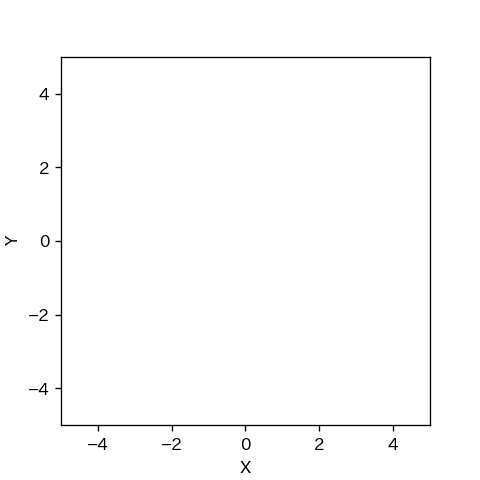

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
            
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_kidnap_phantom(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m,phantom_prob=0.1),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


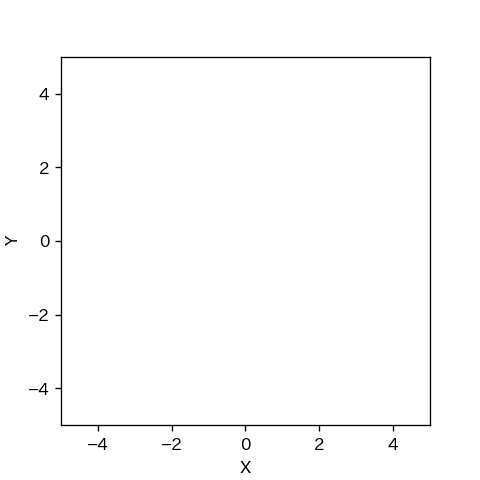

(array([ 2.81880327,  1.54354888, -1.9381811 ]),
 array([-2.69719697,  0.68908441,  3.13279556]))

In [4]:
trial_kidnap_phantom(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap_phantom(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [1.99977038 0.64638738 6.59961441] 推定値: [ 1.20247506  1.20794425 -0.0672027 ] 誤差: 0.9752055974394291
1
1 真値: [ 0.12701377 -0.58854789  5.03101979] 推定値: [-2.92012537e-04 -6.16197196e-01  5.04399046e+00] 誤差: 0.13027373475992182
2
2 真値: [ 1.47488039 -4.21335612  5.62907915] 推定値: [ 1.10634567 -3.41880578  5.49864786] 誤差: 0.8758584765418307
3
3 真値: [ 4.74303042 -2.69030001  3.22766208] 推定値: [ 3.81756577 -2.0524031  -2.81778444] 誤差: 1.1240094715584672
4 真値: [-5.96947696  4.83435608  4.67139695] 推定値: [-6.34624641  3.70785587  5.02662171] 誤差: 1.1878374986439275
5 真値: [2.16149465 0.22046555 7.41713105] 推定値: [1.77444911 0.21203944 7.24467055] 誤差: 0.387137247971426
4
6 真値: [-1.43326846 -2.98414555  1.98610717] 推定値: [-0.26644814 -1.39959901  2.37098071] 誤差: 1.9678052214491526
7 真値: [ 2.91201234 -0.31174435  5.88757185] 推定値: [3.30307795 0.07754006 6.31337739] 誤差: 0.5517922282459017
5
8 真値: [-6.56539533 -0.73555538  4.78406583] 推定値: [-4.68967904 -1.06745644  5.87442085] 誤差: 1.9048542982205223


C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-0.05462112 -4.41031074  2.6538547 ] 推定値: [ 0.47536321 -0.80809382  7.85465846] 誤差: 3.640995768182316
21 真値: [ 4.40380224 -1.6061572   8.28108046] 推定値: [ 2.38867569 -2.8614608   7.87708945] 誤差: 2.3741360801893863
22 真値: [-1.37550144 -4.13850211  7.19076487] 推定値: [-2.01956204 -4.02075636  7.1570936 ] 誤差: 0.6547351591560315
13
23 真値: [ 2.67451732 -6.09226457  6.72578552] 推定値: [-0.59122378 -2.24408523  5.19239193] 誤差: 5.047132763511095
24 真値: [-1.85914923 -1.34484498  1.91891523] 推定値: [-0.79516237  0.22467537  2.33438595] 誤差: 1.8961704018007832
25 真値: [-4.99869362 -3.03921065  6.04466987] 推定値: [-5.02634875 -3.1958809   5.77552788] 誤差: 0.15909234761451094
14
26 真値: [ 2.11515917 -1.80243252  4.74896619] 推定値: [ 1.54684812 -2.20839942 -0.90055372] 誤差: 0.698417188769776
15
27 真値: [3.27880832 1.98618318 8.03623371] 推定値: [3.59416265 2.25451329 2.09291709] 誤差: 0.41406448764452825
16
28 真値: [4.00146404 5.57692656 3.6644697 ] 推定値: [4.37850463 0.91984313 7.71834547] 誤差: 4.672321231118453
29 